In [245]:
'''
  Variational Autoencoder (VAE) with the Keras Functional API.
  adapted from: https://www.machinecurve.com/index.php/2019/12/30/how-to-create-a-variational-autoencoder-with-keras/ (12.12.2021)
  further sources:
  https://pythonprogramming.net/autoencoders-tutorial/ (15.12.2021)
  https://www.geeksforgeeks.org/role-of-kl-divergence-in-variational-autoencoders/ (15.12.2021)
  http://louistiao.me/posts/implementing-variational-autoencoders-in-keras-beyond-the-quickstart-tutorial/ (16.12.2021)
  https://jaketae.github.io/study/vae/ (16.12.2021)
  https://towardsdatascience.com/variational-autoencoders-as-generative-models-with-keras-e0c79415a7eb (16.12.2021)
  https://www.tensorflow.org/tutorials/generative/cvae (16.12.2021)

'''

import keras
import tensorflow as tf
import tensorflow_probability as tfp
from keras.layers import Input, Flatten, Dense, Lambda, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
tfd = tfp.distributions

TODO:
- refactor and document
- visualize required epochs for latent_dim=32
- answer questions

In [246]:
# Load MNIST dataset
(input_train, target_train), (input_test, target_test) = mnist.load_data()

In [247]:
tf.compat.v1.disable_eager_execution()

# Data & model configuration
img_width, img_height = input_train.shape[1], input_train.shape[2]
batch_size = 128
no_epochs = 100
validation_split = 0.2
verbosity = 1
latent_dim = 32
num_channels = 1

In [248]:
# Reshape data
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)
input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

In [249]:
# # =================
# # Encoder
# # =================

# Definition
i = Input(shape=input_shape, name='encoder_input')
x = Flatten()(i)
x = Dense(256, activation="relu")(x)
x = Dense(256, activation='relu')(x)
mu = Dense(latent_dim, name='latent_mu')(x)
sigma = Dense(latent_dim, name='latent_sigma')(x)

# Define sampling with reparameterization trick
def sample_z(args):
    mu, sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch, dim))
    return mu + K.exp(sigma / 2) * eps

z = Lambda(sample_z, output_shape=(latent_dim,), name='z')([mu, sigma])

# Instantiate encoder
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 flatten_14 (Flatten)           (None, 784)          0           ['encoder_input[0][0]']          
                                                                                                  
 dense_70 (Dense)               (None, 256)          200960      ['flatten_14[0][0]']             
                                                                                                  
 dense_71 (Dense)               (None, 256)          65792       ['dense_70[0][0]']               
                                                                                            

In [250]:
# =================
# Decoder
# =================

# Definition
d_i = Input(shape=(latent_dim,), name='decoder_input')
x = keras.layers.Dense(256, activation="relu")(d_i)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dense(784, activation="relu")(x)
o = keras.layers.Reshape(input_shape)(x)

# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 32)]              0         
                                                                 
 dense_72 (Dense)            (None, 256)               8448      
                                                                 
 dense_73 (Dense)            (None, 256)               65792     
                                                                 
 dense_74 (Dense)            (None, 784)               201488    
                                                                 
 reshape_14 (Reshape)        (None, 28, 28, 1)         0         
                                                                 
Total params: 275,728
Trainable params: 275,728
Non-trainable params: 0
_________________________________________________________________


In [251]:
# =================
# VAE as a whole
# =================

# Instantiate VAE
vae_outputs = decoder(encoder(i)[2])
vae = Model(i, vae_outputs, name='vae')
vae.summary()


Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 32),              283200    
                              (None, 32),                        
                              (None, 32)]                        
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         275728    
                                                                 
Total params: 558,928
Trainable params: 558,928
Non-trainable params: 0
_________________________________________________________________


In [252]:
# Define loss
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)


In [253]:
# Compile VAE
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", patience=10)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
vae.compile(optimizer=opt, loss=kl_reconstruction_loss)

# Train autoencoder
history = vae.fit(input_train, input_train, epochs=100, batch_size=batch_size, validation_data=(input_test, input_test), callbacks=[early_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 7s 109us/sample - loss: 248.8004 - val_loss: 218.7024
Epoch 2/100
60000/60000 [==============================] - 5s 82us/sample - loss: 209.6438 - val_loss: 213.8056
Epoch 3/100
60000/60000 [==============================] - 5s 82us/sample - loss: 208.1534 - val_loss: 198.4035
Epoch 4/100
60000/60000 [==============================] - 5s 82us/sample - loss: 205.8072 - val_loss: 215.2572
Epoch 5/100
60000/60000 [==============================] - 5s 82us/sample - loss: 198.6400 - val_loss: 189.1990
Epoch 6/100
60000/60000 [==============================] - 5s 82us/sample - loss: 198.9427 - val_loss: 199.9124
Epoch 7/100
60000/60000 [==============================] - 5s 84us/sample - loss: 206.4610 - val_loss: 212.2169
Epoch 8/100
60000/60000 [==============================] - 5s 84us/sample - loss: 196.5687 - val_loss: 188.4145
Epoch 9/100
60000/60000 [============================

loss = 197

### Subtask 1: What activation functions should be used for the mean and standard deviation of the approximate posterior and the likelihood?

### Subtask 2: What might the reason if we obtain good reconstructed but bad generated digits?

??
When the reconstruction works well but the generation does not, the VAE remembers the training data too well and generalizes bad. The model overfits the given data.

### Subtask 3: Train the VAE

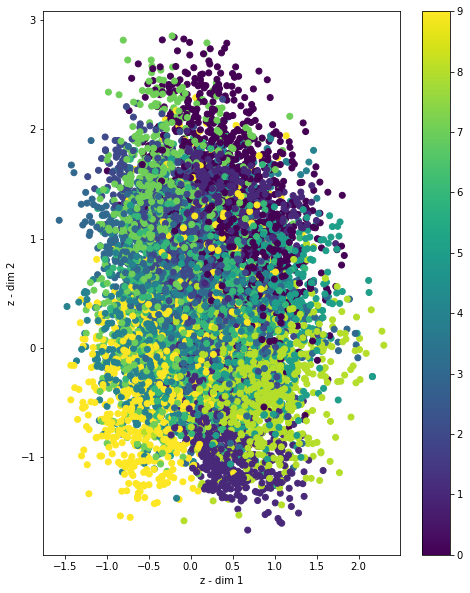

In [254]:
# =================
# adapted from: https://keras.io/examples/variational_autoencoder_deconv/
# =================
def viz_latent_space(encoder, data):
    input_data, target_data = data
    mu, _, _ = encoder.predict(input_data)
    plt.figure(figsize=(8, 10))
    plt.scatter(mu[:, 0], mu[:, 1], c=target_data)
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    plt.colorbar()
    plt.show()

# Plot results
data = (input_test, target_test)
viz_latent_space(encoder, data)

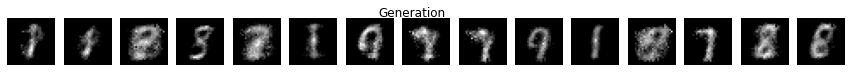

In [255]:
def vis_generation(num_samples):
    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples, 1))
    fig.suptitle('Generation')
    for i in range(num_samples):
        rand = np.random.normal(size=latent_dim) * 4
        out = decoder.predict(np.array([rand]))
        out_reshaped = out[0].reshape(img_width, img_height, num_channels)

        axs[i].imshow(out_reshaped, cmap="gray")
        axs[i].axis('off')

vis_generation(15)

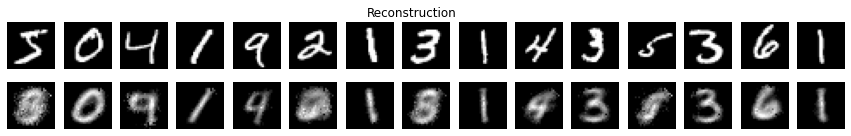

In [256]:
def vis_reconstruction(num_samples):
    fig, axs = plt.subplots(2, num_samples, figsize=(num_samples, 2))
    fig.suptitle('Reconstruction')
    for i in range(num_samples):
        axs[0][i].imshow(input_train[i], cmap="gray")
        axs[0][i].axis('off')
    for i in range(num_samples):
        out = vae.predict([input_train[i].reshape(-1, 28, 28, 1) ])[0]
        axs[1][i].imshow(out, cmap="gray")
        axs[1][i].axis('off')


vis_reconstruction(15)

### Subtask 4: Plot the loss curve

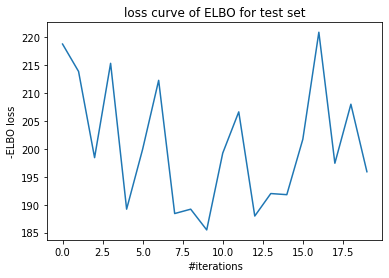

In [257]:
#print(vae.history.history)
loss_history = history.history['val_loss']

plt.plot(loss_history)
plt.title("loss curve of ELBO for test set")
plt.xlabel('#iterations')
plt.ylabel('-ELBO loss')
plt.show()

### Subtask 5: VAE with latent_dim=32

change latent_dim=32 and rerun

Results: